In [164]:
"""
Notebook conclusion
My implementation of the Wishart log_pdf ranks solutions identially to scipy
"""

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import pyext.src.ulpdf as ulpdf
import scipy.stats as stats
import pyext.src.matrix as mat
import pyext.src.pynet_rng as rng
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16


In [52]:
p = 7
O = np.ones((p, p))
diags = np.diag_indices(p)
nu = p + 1
O[diags] = 2.1
O[0, 3] = -1.3
O[3, 5] = -1.7
O[4, 6] = 2.19278
V = 1/p * O
rseed = 2098
key = jax.random.PRNGKey(rseed)
assert mat.is_positive_definite(V)


In [53]:
sp_wish = stats.wishart(df=nu, scale=V)
def sp_vs_my_implementation(key, V, nu, p):
    A = rng.standard_wishart(key, p, nu)
    L = jsp.linalg.cholesky(V, lower=True)
    S = L @ A @ A.T @ L.T
    
    sp_lpdf = sp_wish.logpdf(S)
    my_lpdf = ulpdf.wish_bart(A, nu, L, p)
    my_lpdf_S = ulpdf.wish_bart_from_S(S, nu, L, p)
    return sp_lpdf, my_lpdf, my_lpdf_S

ntests = 1000
k1 = key
results = np.zeros((ntests, 3))
for i in range(ntests):
    key, k1 = jax.random.split(k1)
    sp_lpdf, my_lpdf, my_lpdf_S = sp_vs_my_implementation(key, V, nu, p)
    results[i, 0] = sp_lpdf
    results[i, 1] = my_lpdf
    results[i, 2] = my_lpdf_S


Text(0, 0.5, 'my log pdf')

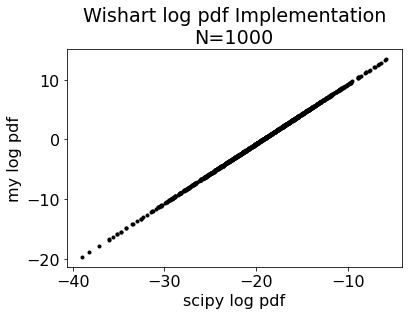

In [165]:
plt.plot(results[:, 0], results[:, 1], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

Text(0, 0.5, 'my log pdf')

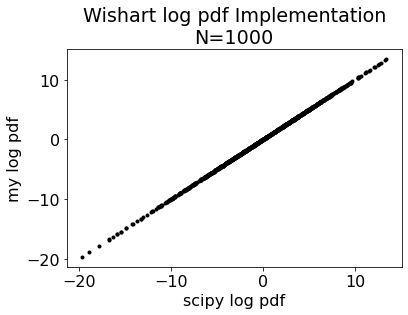

In [166]:
plt.plot(results[:, 1], results[:, 2], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

Text(0, 0.5, 'my log pdf')

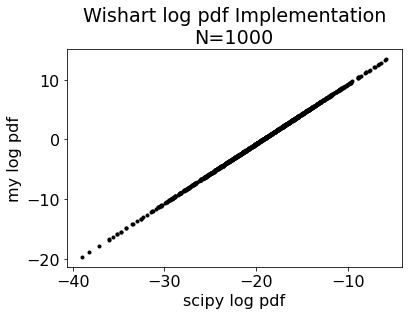

In [167]:
plt.plot(results[:, 0], results[:, 2], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

In [69]:
# Compare the speed of execution
import timeit
from functools import partial
L = jsp.linalg.cholesky(V, lower=True)
A = rng.standard_wishart(key, p, nu)
S = L @ A @ A.T @ L.T

spwish = stats.wishart(df=nu, scale=V)
my_wish = ulpdf.wish_bart
f = partial(ulpdf.wish_bart, p=p)
jwish = jax.jit(f)


In [74]:
%timeit spwish.logpdf(S)

113 µs ± 226 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
%timeit my_wish(A, nu, L, p).block_until_ready()

1.93 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
jwish(A, nu, L)

DeviceArray(5.420307, dtype=float32)

In [77]:
%timeit jwish(A, nu, L).block_until_ready()

15.9 µs ± 53.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [78]:
f2 = partial(f, nu=nu, L=L, p=p)
jf2 = jax.jit(f2)
jf2(A).block_until_ready()

DeviceArray(5.420307, dtype=float32)

In [82]:
%timeit jf2(A).block_until_ready()

12.5 µs ± 55.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [86]:
%timeit numpy_version(A, nu, L, p)

615 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
# Custom Numpy and Scipy
import scipy as sp
def numpy_version(A, nu, L, p):
    log_det_V = 2 * np_log_det_tri(L)                                                                                                                                
    log_det_S = 2 * np_log_det_tri(A) + log_det_V                                                                                                             
    trace_term = - np_trace_term(L, A)                                                                                                                    
    log_gamma = sp.special.multigammaln(nu , p)                                                                                    
    s = (0.5 * (nu - 1 - p) * log_det_S - (0.5 * trace_term) - (0.5 * (nu * p) * np.log(2)) - (0.5 * nu) * log_det_V - log_gamma)            
    return -s


def np_log_det_tri(T):
    return np.sum(np.log(T.diagonal()))

def np_trace_term(L, A):
    return np.trace(sp.linalg.inv(L.T) @ A @ A.T @ L.T)


In [85]:
numpy_version(A, nu, L, p)

5.4202979037677395

In [95]:
import pandas as pd
# Mini Benchmark Results
rows = ['sp frozen lpdf(S| n, V)', 'my_imp', 'my_jit', 'my_jf2', 'numpy']
columns = ['mean (micro s)', 'std', 'log10 nloops' ]
data = np.array([[113, 0.226, 5],
                 [1930, 18.8, 2],
                 [15.9, 0.53, 5],
                 [12.5, 0.556, 5],
                 [615, 11.8, 4]])
micro_benchmark = pd.DataFrame(index=rows, columns=columns, data=data)



Text(0, 0.5, 'mean time per loop (µs)')

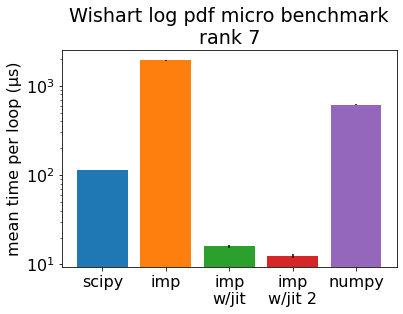

In [172]:
cm = mpl.cm.tab10
ax = plt.bar(np.arange(len(micro_benchmark)), 
        micro_benchmark.iloc[:, 0].values, 
        yerr=micro_benchmark.iloc[:, 1],
        color=cm.colors[0:5],
        tick_label=['scipy', 'imp', 'imp\nw/jit', 'imp\nw/jit 2', 'numpy'])
#ticks = ax.get_xticks()
#ax.set_xticks(ticks, labels=list(micro_benchmark.index))
plt.title(f"Wishart log pdf micro benchmark\nrank {p}")
plt.yscale("log")
plt.ylabel("mean time per loop (µs)")
#plt.xticks(labels=list(micro_benchmark.index))